# Lab 13 - Unet achitecture implimentaytion in pytorch

importing **pytorch** and other **libraries** 

In [ ]:
import torch
import os
from torch.utils.data import Dataset
import cv2
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import ReLU
from torchvision import transforms
from torch.nn import functional as F
from torch.nn import BCEWithLogitsLoss
from torch.nn import ModuleList
from torch.optim import Adam
from torchvision.transforms import CenterCrop
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import MaxPool2d
from torch.nn import Module
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
classes = 1 #binary classes so -> one_class
depths = 3 # and number of levels/depth in the U-Net model
batch_size = 44  
# reshaping dimensions of input images
w_inpImg , h_inpImg = 128 , 128
# if device gpu-> cuda else cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
# memory usame detrmined for dataloader part
memory_usage = True if device == "cuda" else False
# root directory path of the dataset
rootdir = os.path.join("/content/drive/MyDrive/dataset2", "train")
images_data = os.path.join(rootdir, "images")
masks_data = os.path.join(rootdir, "masks")

### **Class**: Salt resources identification dataset 

---


In [ ]:
class SaltDataset(Dataset):
	def __init__(self, imgPaths, maskPaths, transforms):

		#initializing wiith params
		self.maskPaths = maskPaths
		self.imgPaths = imgPaths
		self.transforms = transforms

# defined functions of len and detitem for the given pytorch dataset class
	def __len__(self):
		return len(self.imgPaths) # len of the total images containes in the train folder
	
	def __getitem__(self, index):
		imagePath = self.imgPaths[index]
		#image processing using numpy and opencv(converting images from BGR->RGB aand segementation mask of image to -> grayscale)
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[index], 0)
	#transformations part 
		if self.transforms is not None:
			#apply defined transformations to both image and seg mask
			myimage = self.transforms(image)
			mymask = self.transforms(mask)
		return (myimage, mymask)

### **Class**: Unit for each unit of architecture

> **Class Encoder**: left part of architecteure


> **Class Decoder**: right part of architecteure

> **Main parent class** of model implimentation





In [ ]:
# Architechture implimentation 
class Unit (Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		#desighn  each unit structure (conv + relu + conv )
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	
	def forward(self, x):
		# apply  each unit structure (conv + relu + conv ) to every image and return results
		x = self.conv1(x)
		y = self.relu(x)
		y_hat = self.conv2(y)
	
		return y_hat 

# --------------------------------Left part of architechture----------------
class LeftEncoder (Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# modulet llist to iterate over the left part of encoder
		self.encoderBlks = ModuleList( [Unit(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
	#maxpool layer of arc
		self.pool = MaxPool2d(2)
	
	def forward(self, x):
		# initializing a list to store the each blocks output for decoder input
		each_block_Out = []
		#looping over each block 
		for each in self.encoderBlks:
			x = each(x) # encoder gives an output thet
			each_block_Out.append(x) # is stored in tha list 
			x = self.pool(x) # and then max pool is used
		return each_block_Out

#--------------------------------Right part of architechture----------------
class RightDecoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# with the help of module list we are able to to again rehape yto orignnal image shape using  up convolution and decoder
		# blocks respectively
		self.channels = channels # number of chennals
		self.upconvs = ModuleList( [ConvTranspose2d(channels[i], channels[i + 1], 2, 2) for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList( [Unit(channels[i], channels[i + 1]) 	for i in range(len(channels) - 1)])
	
	def forward(self, x, encoderFeatures):
		for i in range(len(self.channels) - 1):
			# each encoder outpute passes throuhgh upconvolution
			x = self.upconvs[i](x)
#now here we conCat the output of each encoder output and add to decoder input
			encFeat = self.crop(encoderFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		return x

	def crop(self, encoderFeatures, x):
		(_, _, Hght, Wdth) = x.shape
			# cropping features to desired dimentions
		encoderFeatures = CenterCrop([Hght, Wdth])(encoderFeatures)
		return encoderFeatures
#----------------------------------------------MAIN MODEL CLASS----------------------------
class UNet(Module):
	def __init__(self, encoderChannels=(3, 16, 32, 64), decoderChannels=(64, 32, 16), numClasses=1, retainDim=True, outSize=(h_inpImg,  w_inpImg)):
		super().__init__()
		# encoder and decoder for the model 
		self.encoder = LeftEncoder(encoderChannels)
		self.decoder = RightDecoder(decoderChannels)
		self.parent = Conv2d(decoderChannels[-1], numClasses, 1) # storing the given class variables
		self.retainDim = retainDim # we have to get the orignal dimentions back 
		self.outSize = outSize # output size mentions

	def forward(self, x):
		encoderFeatures = self.encoder(x) # get features from encPart
		# now passing each feature in reverse order bacause now we are moving down to up
		decoderFeatures = self.decoder(encoderFeatures[::-1][0], encoderFeatures[::-1][1:])
		# pasiing feat to conv2d from decoder channels to have th esegmentations mask of each
		seg_mask = self.parent(decoderFeatures)
		# interpolation and resizing the out put
		if self.retainDim:
			seg_mask = F.interpolate(seg_mask, self.outSize)
		return seg_mask
  

### Splitting data into training/testing on Slat resource identification dataset (using *sckit-learn*)

In [ ]:
# sorting eah images and masks, given -> paths
imgPaths = sorted(list(paths.list_images(images_data)))
maskPaths = sorted(list(paths.list_images(masks_data)))
#splitting train test split using sk-learn library
split = train_test_split(imgPaths, maskPaths, test_size=0.15, random_state=42)
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

print("\t Data split and  saving completed ...!")

	 Data split and  saving completed ...!


In [ ]:
# applying transformations

In [ ]:
# defining transformations
transforms = transforms.Compose([transforms.ToPILImage(), transforms.Resize((h_inpImg, w_inpImg)), transforms.ToTensor()])
# splitting into two train nad test dataset
trainDS = SaltDataset(imgPaths=trainImages, maskPaths=trainMasks, transforms=transforms)
testDS = SaltDataset(imgPaths=testImages, maskPaths=testMasks, transforms=transforms)

#training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True, batch_size=batch_size, pin_memory=memory_usage, num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,	batch_size=batch_size, pin_memory=memory_usage,	num_workers=os.cpu_count())
print("Images in the test folder dataset: " , len(testDS))
print("Images in the train folder dataset: " , len(trainDS))

Images in the test folder dataset:  600
Images in the train folder dataset:  3400


In [ ]:
# init -the model to GPU / CPU
unet = UNet().to(device)
#  loss and optimizer  function
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=0.001)
# steps per epoch for training and test set
trainSteps = len(trainDS) // batch_size
testSteps = len(testDS) // batch_size

In [ ]:
EPOCHS = 30 # number of epochs
print("Training on "+str(EPOCHS)+ " epochs...!")
for each in tqdm(range(EPOCHS)):
	unet.train()
	# set training and validation loss to zero
	TrainLoss = 0
	TestLoss = 0
	# looping for training data
	for (i, (x, y)) in enumerate(trainLoader):
		(x, y) = (x.to(device), y.to(device))
		#  calculate the training loss / pred
		pred = unet(x)
		loss = lossFunc(pred, y)
		#  zero  gradients, then backpropagation, 
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		TrainLoss += loss
	# no need autograd computationsaa
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			TestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avg_train_loss = TrainLoss / trainSteps
	avg_test_loss = TestLoss / testSteps
	print("\n \t\t EPOCH: ["  +str(each + 1)+ "/"  +str(EPOCHS)+ "]\n ")
	print("[Train loss: "+str(avg_train_loss)+"]\n[Test loss:"+ str(avg_test_loss)+"]")
	

Training on 30 epochs...!


  3%|▎         | 1/30 [02:33<1:14:12, 153.55s/it]


 		 EPOCH: [1/30]
 
[Train loss: tensor(0.5866, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.5900, device='cuda:0')]


  7%|▋         | 2/30 [02:52<34:41, 74.32s/it]   


 		 EPOCH: [2/30]
 
[Train loss: tensor(0.5669, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.5839, device='cuda:0')]


 10%|█         | 3/30 [03:10<21:48, 48.48s/it]


 		 EPOCH: [3/30]
 
[Train loss: tensor(0.5658, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.5838, device='cuda:0')]


 13%|█▎        | 4/30 [03:27<15:44, 36.35s/it]


 		 EPOCH: [4/30]
 
[Train loss: tensor(0.5634, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.5887, device='cuda:0')]


 17%|█▋        | 5/30 [03:45<12:19, 29.58s/it]


 		 EPOCH: [5/30]
 
[Train loss: tensor(0.5659, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.5791, device='cuda:0')]


 20%|██        | 6/30 [04:03<10:12, 25.54s/it]


 		 EPOCH: [6/30]
 
[Train loss: tensor(0.5579, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.5718, device='cuda:0')]


 23%|██▎       | 7/30 [04:20<08:48, 22.99s/it]


 		 EPOCH: [7/30]
 
[Train loss: tensor(0.5279, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.4445, device='cuda:0')]


 27%|██▋       | 8/30 [04:38<07:49, 21.34s/it]


 		 EPOCH: [8/30]
 
[Train loss: tensor(0.4302, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.4341, device='cuda:0')]


 30%|███       | 9/30 [04:56<07:04, 20.23s/it]


 		 EPOCH: [9/30]
 
[Train loss: tensor(0.4045, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.4003, device='cuda:0')]


 33%|███▎      | 10/30 [05:14<06:28, 19.44s/it]


 		 EPOCH: [10/30]
 
[Train loss: tensor(0.3899, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3885, device='cuda:0')]


 37%|███▋      | 11/30 [05:32<06:00, 18.95s/it]


 		 EPOCH: [11/30]
 
[Train loss: tensor(0.3722, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3966, device='cuda:0')]


 40%|████      | 12/30 [05:50<05:40, 18.91s/it]


 		 EPOCH: [12/30]
 
[Train loss: tensor(0.3876, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3911, device='cuda:0')]


 43%|████▎     | 13/30 [06:08<05:15, 18.57s/it]


 		 EPOCH: [13/30]
 
[Train loss: tensor(0.3700, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3679, device='cuda:0')]


 47%|████▋     | 14/30 [06:26<04:53, 18.37s/it]


 		 EPOCH: [14/30]
 
[Train loss: tensor(0.3603, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3605, device='cuda:0')]


 50%|█████     | 15/30 [06:44<04:35, 18.37s/it]


 		 EPOCH: [15/30]
 
[Train loss: tensor(0.3505, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3575, device='cuda:0')]


 53%|█████▎    | 16/30 [07:03<04:19, 18.50s/it]


 		 EPOCH: [16/30]
 
[Train loss: tensor(0.3556, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3515, device='cuda:0')]


 57%|█████▋    | 17/30 [07:21<03:56, 18.23s/it]


 		 EPOCH: [17/30]
 
[Train loss: tensor(0.3460, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3482, device='cuda:0')]


 60%|██████    | 18/30 [07:39<03:37, 18.09s/it]


 		 EPOCH: [18/30]
 
[Train loss: tensor(0.3566, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3737, device='cuda:0')]


 63%|██████▎   | 19/30 [07:56<03:17, 17.98s/it]


 		 EPOCH: [19/30]
 
[Train loss: tensor(0.3447, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3703, device='cuda:0')]


 67%|██████▋   | 20/30 [08:14<02:58, 17.86s/it]


 		 EPOCH: [20/30]
 
[Train loss: tensor(0.3461, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3338, device='cuda:0')]


 70%|███████   | 21/30 [08:32<02:40, 17.82s/it]


 		 EPOCH: [21/30]
 
[Train loss: tensor(0.3427, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3344, device='cuda:0')]


 73%|███████▎  | 22/30 [08:49<02:21, 17.74s/it]


 		 EPOCH: [22/30]
 
[Train loss: tensor(0.3184, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3539, device='cuda:0')]


 77%|███████▋  | 23/30 [09:07<02:03, 17.69s/it]


 		 EPOCH: [23/30]
 
[Train loss: tensor(0.3307, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3644, device='cuda:0')]


 80%|████████  | 24/30 [09:24<01:45, 17.56s/it]


 		 EPOCH: [24/30]
 
[Train loss: tensor(0.3331, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.5247, device='cuda:0')]


 83%|████████▎ | 25/30 [09:42<01:27, 17.56s/it]


 		 EPOCH: [25/30]
 
[Train loss: tensor(0.4287, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3857, device='cuda:0')]


 87%|████████▋ | 26/30 [09:59<01:10, 17.56s/it]


 		 EPOCH: [26/30]
 
[Train loss: tensor(0.3467, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3390, device='cuda:0')]


 90%|█████████ | 27/30 [10:17<00:52, 17.54s/it]


 		 EPOCH: [27/30]
 
[Train loss: tensor(0.3373, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3367, device='cuda:0')]


 93%|█████████▎| 28/30 [10:34<00:35, 17.59s/it]


 		 EPOCH: [28/30]
 
[Train loss: tensor(0.3073, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3441, device='cuda:0')]


 97%|█████████▋| 29/30 [10:52<00:17, 17.53s/it]


 		 EPOCH: [29/30]
 
[Train loss: tensor(0.3171, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3002, device='cuda:0')]


100%|██████████| 30/30 [11:10<00:00, 22.35s/it]


 		 EPOCH: [30/30]
 
[Train loss: tensor(0.2927, device='cuda:0', grad_fn=<DivBackward0>)]
[Test loss:tensor(0.3169, device='cuda:0')]


### Making a prediction on test image 

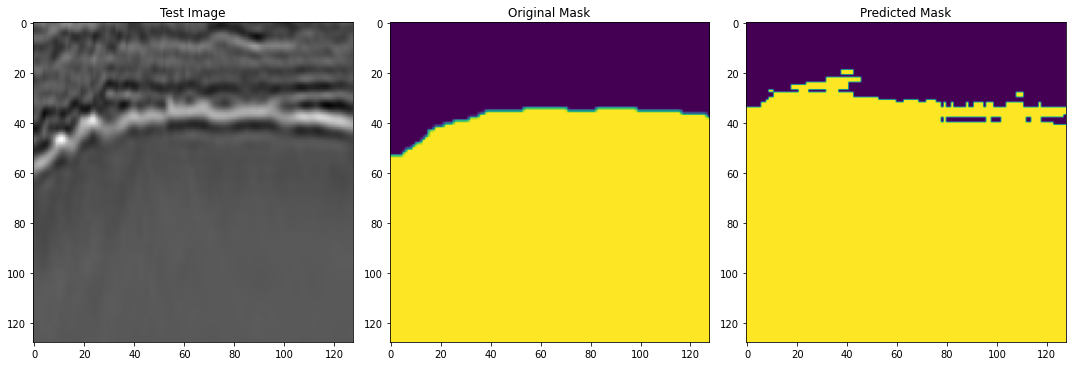

In [ ]:
from google.colab.patches import cv2_imshow
# saving the model 
torch.save(unet.state_dict(), '/content/drive/MyDrive/dataset2/MODEL.pth')
unet.load_state_dict(torch.load('/content/drive/MyDrive/dataset2/MODEL.pth'))
unet.eval()
# no need of gradient computing
with torch.no_grad():
  # image test file name
  # filename = 'fff987cdb3mask.png'
  pixels = 255.0
  maskOftestImage = '/content/drive/MyDrive/dataset2/fff987cdb3mask.png'
  maskOftestImage = cv2.imread(maskOftestImage, 0)
  maskOftestImage = cv2.resize(maskOftestImage, (w_inpImg,h_inpImg))

  # a test image proceesed for prediction scaling its values to 255 rane 
  test_image = cv2.imread('/content/drive/MyDrive/dataset2/fff987cdb3image.png')
  test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
  test_image = test_image.astype("float32")
  test_image = test_image / pixels

  # changing dimebntions of image to our default size
  test_image = cv2.resize(test_image, (w_inpImg, h_inpImg))
  orig_test_image = test_image.copy()# genrating a copy for visualization purpose

  # creating a tensor of the given test image
  test_image = np.transpose(test_image, (2, 0, 1))
  test_image = np.expand_dims(test_image, 0)
  test_image = torch.from_numpy(test_image).to(device)
  #predicting on test image passing it to tanh and convertint it to numpy 
  pred_testMask = unet(test_image).squeeze() # sueezing it by dimentions 
  pred_testMask = torch.sigmoid(pred_testMask) #// pred is almost equal to tanh and relu fn
  pred_testMask = pred_testMask.cpu().numpy()
  # used a threshold of 0.5 to filter the best / good prediction
  pred_testMask = (pred_testMask > 0.5) * int(pixels)
  pred_testMask = pred_testMask.astype(np.uint8)
  # plotting the output
  fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
  axis[0].set_title("Test Image")
  axis[1].set_title("Original Mask")
  axis[2].set_title("Predicted Mask")
  axis[0].imshow(orig_test_image)
  axis[2].imshow(pred_testMask)
  axis[1].imshow(maskOftestImage)

  fig.tight_layout()
  fig.show()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Using a pretrained model


In [ ]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

In [ ]:
import segmentation_models_pytorch as smp
pretrainedUnet=smp.Unet()

In [ ]:
# no need of gradient computing
pretrainedUnet.eval()
with torch.no_grad():
  # image test file name
  # filename = 'fff987cdb3mask.png'
  pixels = 255.0
  maskOftestImage = '/content/drive/MyDrive/dataset2/fff987cdb3mask.png'
  maskOftestImage = cv2.imread(maskOftestImage, 0)
  maskOftestImage = cv2.resize(maskOftestImage, (w_inpImg,h_inpImg))

  # a test image proceesed for prediction scaling its values to 255 rane 
  test_image = cv2.imread('/content/drive/MyDrive/dataset2/fff987cdb3image.png')
  test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
  test_image = test_image.astype("float32")
  test_image = test_image / pixels

  # changing dimebntions of image to our default size
  test_image = cv2.resize(test_image, (w_inpImg, h_inpImg))
  orig_test_image = test_image.copy()# genrating a copy for visualization purpose

  # creating a tensor of the given test image
  test_image = np.transpose(test_image, (2, 0, 1))
  test_image = np.expand_dims(test_image, 0)
  test_image = torch.from_numpy(test_image).to(device)
  #predicting on test image passing it to tanh and convertint it to numpy 
  pred_testMask = pretrainedUnet(test_image).squeeze() # sueezing it by dimentions 
  pred_testMask = torch.sigmoid(pred_testMask) #// pred is almost equal to tanh and relu fn
  pred_testMask = pred_testMask.cpu().numpy()
  # used a threshold of 0.5 to filter the best / good prediction
  pred_testMask = (pred_testMask > 0.5) * int(pixels)
  pred_testMask = pred_testMask.astype(np.uint8)
  # plotting the output
  fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
  axis[0].set_title("Test Image")
  axis[1].set_title("Original Mask")
  axis[2].set_title("Pretrained Mask")
  axis[0].imshow(orig_test_image)
  axis[2].imshow(pred_testMask)
  axis[1].imshow(maskOftestImage)

  fig.tight_layout()
  fig.show()